# ML Project - Layer 8

In [1]:
datasets_path = "./speech-based-classification-layer-8/"

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler


In [3]:
train_df = pd.read_csv(datasets_path + "train.csv")
valid_df = pd.read_csv(datasets_path + "valid.csv")
test_df = pd.read_csv(datasets_path + "test.csv")
train_df.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_763,feature_764,feature_765,feature_766,feature_767,feature_768,label_1,label_2,label_3,label_4
0,0.071810,0.068413,-0.022749,0.086143,0.026361,-0.028817,0.199237,-0.287368,-0.059560,-0.043694,...,0.004646,0.123011,0.043040,-0.042152,0.026225,0.072623,45,NaN,1,6
1,0.030930,0.024088,0.057811,-0.230877,-0.146281,0.102807,0.128767,-0.146269,0.053893,0.055378,...,0.077742,0.081691,-0.004778,0.171727,-0.026027,0.171089,45,NaN,1,6
2,-0.044019,-0.004626,-0.029383,-0.165376,-0.026611,-0.028142,-0.009649,-0.082088,0.018933,0.006830,...,0.076249,-0.046272,0.027831,0.028096,0.030994,0.009709,45,NaN,1,6
3,-0.086241,0.129585,-0.013893,0.089885,-0.100300,-0.035184,0.240980,-0.128362,-0.072328,-0.019385,...,0.006934,-0.049213,0.078852,0.088323,0.168815,-0.049188,45,NaN,1,6
4,0.126416,0.088338,0.088307,0.020371,0.174417,-0.030560,0.181163,-0.009382,0.085396,0.015823,...,-0.028883,0.110844,-0.041875,0.025686,0.003534,-0.104945,45,NaN,1,6


## Dataset Exploration

In [5]:
print(train_df.shape)
print(valid_df.shape)

(28520, 772)
(750, 772)


How many null values are there in `label_2`?

In [8]:
# train dataset
count = train_df['label_2'].isna().sum()
print("count:", count)
print("percentage: {:.3f}".format(count / train_df.shape[0] * 100))

count: 480
percentage: 1.683


In [10]:
# valid dataset
count = valid_df['label_2'].isna().sum()
print("count:", count)
print("percentage: {:.3f}".format(count / valid_df.shape[0] * 100))

count: 14
percentage: 1.867


Are there any null values in any other column?

In [35]:
null_values_present = train_df.loc[:, ~train_df.columns.isin(['label_2'])].isna().any().any()
print(null_values_present)

False


`label_1` (Speaker ID) column distribuiton

<Axes: xlabel='label_1'>

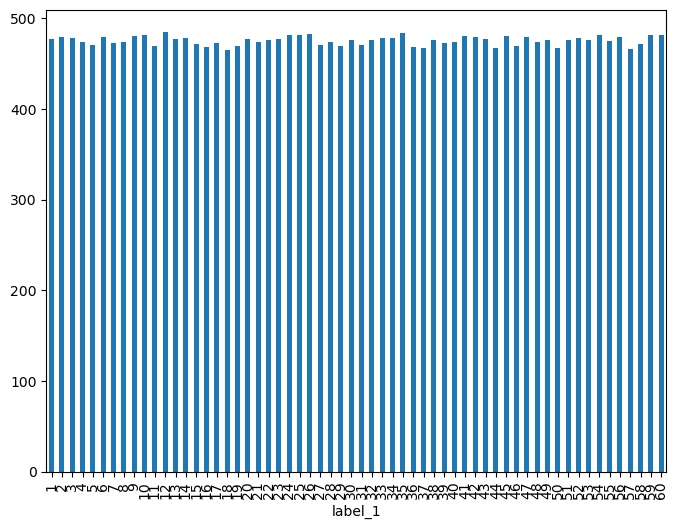

In [11]:
plt.figure(figsize=(8, 6))
train_df['label_1'].value_counts().sort_index().plot(kind='bar')

`label_2` (Speaker Age) column distribuiton

<Axes: xlabel='label_2'>

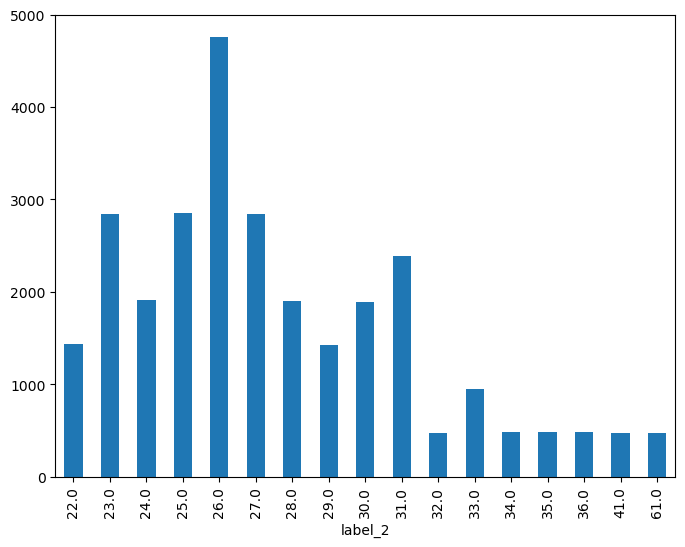

In [53]:
plt.figure(figsize=(8, 6))
train_df['label_2'].value_counts().sort_index().plot(kind='bar')

`label_3` (Speaker Gender) column distribuiton

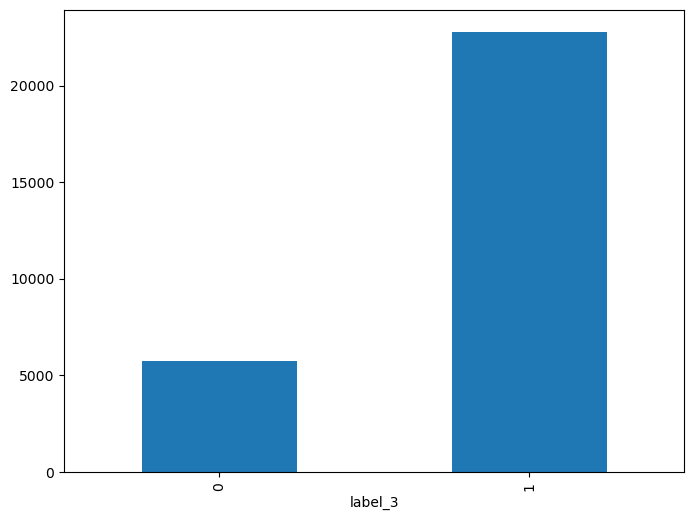

In [14]:
plt.figure(figsize=(8, 6))
train_df['label_3'].value_counts().sort_index().plot(kind='bar')
plt.show()

`label_4` (Speaker Accent) column distribuiton

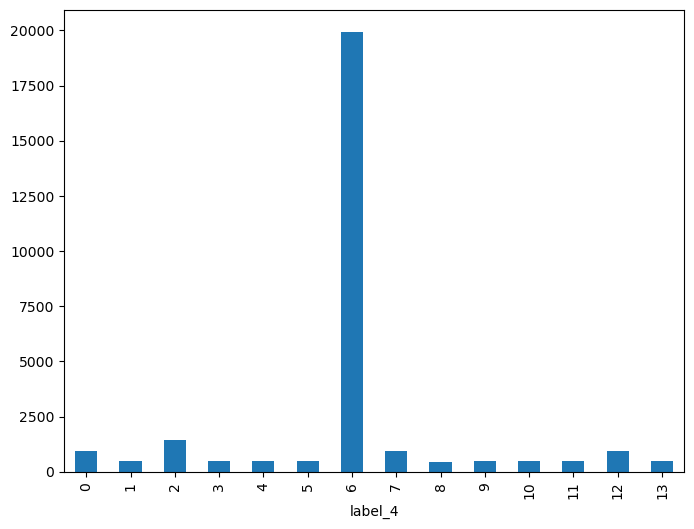

In [16]:
plt.figure(figsize=(8, 6))
train_df['label_4'].value_counts().sort_index().plot(kind='bar')
plt.show()

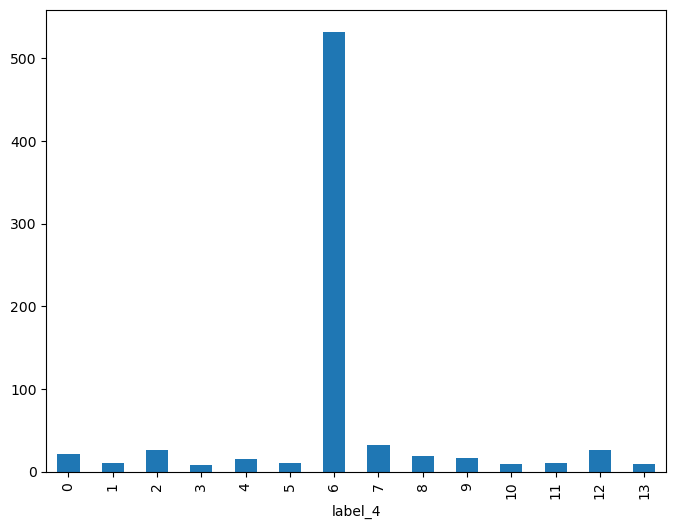

In [8]:
# validation dataset
plt.figure(figsize=(8, 6))
valid_df['label_4'].value_counts().sort_index().plot(kind='bar')
plt.show()

## Handle Missing Data in `label_2`

There are missing data in `label_2`. Let's see the count of data missing rows in `label_2`.

In [4]:
count = train_df['label_2'].isna().sum()
print("missing count in train:", count)
print("missing percentage in trian:", round(count / train_df.shape[0] * 100, 3))

count = valid_df['label_2'].isna().sum()
print("missing count in valid:", count)
print("missing percentage in valid:", round(count / valid_df.shape[0] * 100, 3))

missing count in train: 480
missing percentage in trian: 1.683
missing count in valid: 14
missing percentage in valid: 1.867


Since the count of data missing rows is relatively small compared to the whole dataset, let's drop those rows from the dataset used for `label_2`.

In [5]:
train_df_label_2_missing_removed = train_df.dropna(subset=['label_2'])
valid_df_label_2_missing_removed = valid_df.dropna(subset=['label_2'])

print(train_df_label_2_missing_removed.shape)
print(valid_df_label_2_missing_removed.shape)

(28040, 772)
(736, 772)


## Baseline Models

In this section, several models are trained with their default parameters and checked the accuracy to get an idea about how well they perform. The original feature set is used to train the models. The tested models are KNN, SVM and Random Forest.

The input feature values are scaled using the `StandardScaler`.

In [6]:
train_df_X = train_df.iloc[:, :-4]
# trianing dataset with data missing rows removed considering label_2
train_df_X_missing_removed = train_df_label_2_missing_removed.iloc[:, :-4]

valid_df_X = valid_df.iloc[:, :-4]
# validation dataset with data missing rows removed considering label_2
valid_df_X_missing_removed = valid_df_label_2_missing_removed.iloc[:, :-4]

scaler = StandardScaler()
scaler.fit(train_df_X)
train_df_X_standardized = scaler.transform(train_df_X)
valid_df_X_standardized = scaler.transform(valid_df_X)

scaler2 = StandardScaler()
scaler2.fit(train_df_X_missing_removed)
train_df_X_missing_removed_standardized = scaler2.transform(train_df_X_missing_removed)
valid_df_X_missing_removed_standardized = scaler2.transform(valid_df_X_missing_removed)


### `label_1` (Speaker ID)

In [7]:
train_df_label_1 = train_df["label_1"]
valid_df_label_1 = valid_df["label_1"]

#### KNN

In [ ]:
model_knn_label_1 = KNeighborsClassifier();
model_knn_label_1.fit(train_df_X_standardized, train_df_label_1)

In [ ]:
joblib.dump(model_knn_label_1, "./models/model_knn_label_1_baseline.joblib")

In [19]:
model_knn_label_1 = joblib.load("./models/model_knn_label_1_baseline.joblib")

In [20]:
print("Training set score: " + str(model_knn_label_1.score(train_df_X_standardized, train_df_label_1)))
print("Validation set score: " + str(model_knn_label_1.score(valid_df_X_standardized, valid_df_label_1)))

Training set score: 0.9107643758765779
Validation set score: 0.8293333333333334


#### SVM

In [17]:
model_svm_label_1 = SVC();
model_svm_label_1.fit(train_df_X_standardized, train_df_label_1)

SVC()

In [ ]:
joblib.dump(model_svm_label_1, "./models/model_svm_label_1_baseline.joblib")

In [ ]:
model_svm_label_1 = joblib.load("./models/model_svm_label_1_baseline.joblib")

In [22]:
print("Training set score: " + str(model_svm_label_1.score(train_df_X_standardized, train_df_label_1)))
print("Validation set score: " + str(model_svm_label_1.score(valid_df_X_standardized, valid_df_label_1)))

Training set score: 0.9674263674614306
Validation set score: 0.932


#### Random Forest

In [ ]:
model_rf_label_1 = RandomForestClassifier();
model_rf_label_1.fit(train_df_X_standardized, train_df_label_1)

In [ ]:
joblib.dump(model_rf_label_1, "./models/model_rf_label_1_baseline.joblib")

In [ ]:
model_rf_label_1 = joblib.load("./models/model_rf_label_1_baseline.joblib")

In [30]:
print("Training set score: " + str(model_rf_label_1.score(train_df_X_standardized, train_df_label_1)))
print("Validation set score: " + str(model_rf_label_1.score(valid_df_X_standardized, valid_df_label_1)))

Training set score: 0.9674263674614306
Validation set score: 0.932


### `label_2` (Speaker Age)

In [8]:
train_df_label_2 = train_df_label_2_missing_removed["label_2"]
valid_df_label_2 = valid_df_label_2_missing_removed["label_2"]

#### KNN

In [ ]:
model_knn_label_2 = KNeighborsClassifier();
model_knn_label_2.fit(train_df_X_missing_removed_standardized, train_df_label_2)

In [ ]:
joblib.dump(model_knn_label_2, "./models/model_knn_label_2_baseline.joblib")

In [ ]:
model_knn_label_2 = joblib.load("./models/model_knn_label_2_baseline.joblib")

In [43]:
print("Training set score: " + str(model_knn_label_2.score(train_df_X_missing_removed_standardized, train_df_label_2)))
print("Validation set score: " + str(model_knn_label_2.score(valid_df_X_missing_removed_standardized, valid_df_label_2)))

Training set score: 0.917867332382311
Validation set score: 0.8355978260869565


#### SVM

In [ ]:
model_svm_label_2 = SVC();
model_svm_label_2.fit(train_df_X_missing_removed_standardized, train_df_label_2)

In [ ]:
joblib.dump(model_svm_label_2, "./models/model_svm_label_2_baseline.joblib")

In [25]:
model_svm_label_2 = joblib.load("./models/model_svm_label_2_baseline.joblib")

In [48]:
print("Training set score: " + str(model_svm_label_2.score(train_df_X_missing_removed_standardized, train_df_label_2)))
print("Validation set score: " + str(model_svm_label_2.score(valid_df_X_missing_removed_standardized, valid_df_label_2)))

Training set score: 0.948644793152639
Validation set score: 0.9008152173913043


#### Random Forest

In [ ]:
model_rf_label_2 = RandomForestClassifier();
model_rf_label_2.fit(train_df_X_missing_removed_standardized, train_df_label_2)

In [ ]:
joblib.dump(model_rf_label_2, "./models/model_rf_label_2_baseline.joblib")

In [51]:
model_rf_label_2 = joblib.load("./models/model_rf_label_2_baseline.joblib")

In [52]:
print("Training set score: " + str(model_rf_label_2.score(train_df_X_missing_removed_standardized, train_df_label_2)))
print("Validation set score: " + str(model_rf_label_2.score(valid_df_X_missing_removed_standardized, valid_df_label_2)))

Training set score: 1.0
Validation set score: 0.7676630434782609


### `label_3` (Speaker Gender)

In [9]:
train_df_label_3 = train_df["label_3"]
valid_df_label_3 = valid_df["label_3"]

#### KNN

In [ ]:
model_knn_label_3 = KNeighborsClassifier();
model_knn_label_3.fit(train_df_X_standardized, train_df_label_3)

In [ ]:
joblib.dump(model_knn_label_3, "./models/model_knn_label_3_baseline.joblib")

In [26]:
model_knn_label_3 = joblib.load("./models/model_knn_label_3_baseline.joblib")

In [63]:
print("Training set score: " + str(model_knn_label_3.score(train_df_X_standardized, train_df_label_3)))
print("Validation set score: " + str(model_knn_label_3.score(valid_df_X_standardized, valid_df_label_3)))

Training set score: 0.9879382889200561
Validation set score: 0.984


#### SVM

In [ ]:
model_svm_label_3 = SVC();
model_svm_label_3.fit(train_df_X_standardized, train_df_label_3)

In [ ]:
joblib.dump(model_svm_label_3, "./models/model_svm_label_3_baseline.joblib")

In [27]:
model_svm_label_3 = joblib.load("./models/model_svm_label_3_baseline.joblib")

In [67]:
print("Training set score: " + str(model_svm_label_3.score(train_df_X_standardized, train_df_label_3)))
print("Validation set score: " + str(model_svm_label_3.score(valid_df_X_standardized, valid_df_label_3)))

Training set score: 0.9958274894810659
Validation set score: 1.0


#### Random Forest

In [ ]:
model_rf_label_3 = RandomForestClassifier();
model_rf_label_3.fit(train_df_X_standardized, train_df_label_3)

In [ ]:
joblib.dump(model_rf_label_3, "./models/model_rf_label_3_baseline.joblib")

In [ ]:
model_rf_label_3 = joblib.load("./models/model_rf_label_3_baseline.joblib")

In [71]:
print("Training set score: " + str(model_rf_label_3.score(train_df_X_standardized, train_df_label_3)))
print("Validation set score: " + str(model_rf_label_3.score(valid_df_X_standardized, valid_df_label_3)))

Training set score: 1.0
Validation set score: 0.9653333333333334


### `label_4` (Speaker Accent)

In [10]:
train_df_label_4 = train_df["label_4"]
valid_df_label_4 = valid_df["label_4"]

#### KNN

In [ ]:
model_knn_label_4 = KNeighborsClassifier();
model_knn_label_4.fit(train_df_X_standardized, train_df_label_4)

In [ ]:
joblib.dump(model_knn_label_4, "./models/model_knn_label_4_baseline.joblib")

In [20]:
model_knn_label_4 = joblib.load("./models/model_knn_label_4_baseline.joblib")

In [21]:
print("Training set score: " + str(model_knn_label_4.score(train_df_X_standardized, train_df_label_4)))
print("Validation set score: " + str(model_knn_label_4.score(valid_df_X_standardized, valid_df_label_4)))

Training set score: 0.9531206171107994
Validation set score: 0.92


#### SVM

In [ ]:
model_svm_label_4 = SVC();
model_svm_label_4.fit(train_df_X_standardized, train_df_label_4)

In [ ]:
joblib.dump(model_svm_label_4, "./models/model_svm_label_4_baseline.joblib")

In [24]:
model_svm_label_4 = joblib.load("./models/model_svm_label_4_baseline.joblib")

In [25]:
print("Training set score: " + str(model_svm_label_4.score(train_df_X_standardized, train_df_label_4)))
print("Validation set score: " + str(model_svm_label_4.score(valid_df_X_standardized, valid_df_label_4)))

Training set score: 0.9713884992987377
Validation set score: 0.9386666666666666


#### Random Forest

In [ ]:
model_rf_label_4 = RandomForestClassifier();
model_rf_label_4.fit(train_df_X_standardized, train_df_label_4)

In [ ]:
joblib.dump(model_rf_label_4, "./models/model_rf_label_4_baseline.joblib")

In [12]:
model_rf_label_4 = joblib.load("./models/model_rf_label_4_baseline.joblib")

In [13]:
print("Training set score: " + str(model_rf_label_4.score(train_df_X_standardized, train_df_label_4)))
print("Validation set score: " + str(model_rf_label_4.score(valid_df_X_standardized, valid_df_label_4)))

Training set score: 1.0
Validation set score: 0.768


## PCA

In this section, Pincipal Component Analysis is used to reduce the dimensions of the features. A value of 0.95 is used for the explained variance parameter. The reduced feature set has 311 features.

In [11]:
pca_1 = PCA(n_components=0.95, svd_solver="full")
pca_2 = PCA(n_components=0.95, svd_solver="full")
train_df_X_pca = pca_1.fit_transform(train_df_X_standardized)
valid_df_X_pca = pca_1.transform(valid_df_X_standardized)

train_df_X_missing_removed_pca = pca_2.fit_transform(train_df_X_missing_removed_standardized)
valid_df_X_missing_removed_pca = pca_2.transform(valid_df_X_missing_removed_standardized)

print(train_df_X_pca.shape)
print(valid_df_X_pca.shape)
print(train_df_X_missing_removed_pca.shape)
print(valid_df_X_missing_removed_pca.shape)

(28520, 311)
(750, 311)
(28040, 311)
(736, 311)


## Under-sampling and Over-sampling for `label_4`

In this section, a new dataset is obtained for `label_4` by undersampling the original data set to fix the imbalanced data set for `label_4`. But when later tested, undersampling resulted a very low accuracy. Therefore this approach is dropped. I did not try the oversampling because it results a large number of rows for the training dataset causing a longer training time.

In [36]:
undersampler = RandomUnderSampler(sampling_strategy="majority")
oversampler = RandomOverSampler(sampling_strategy="not majority")

train_df_X_under, train_df_y_under = undersampler.fit_resample(train_df_X_pca, train_df_label_4)

Below is the undersampled dataset for `label_4`.

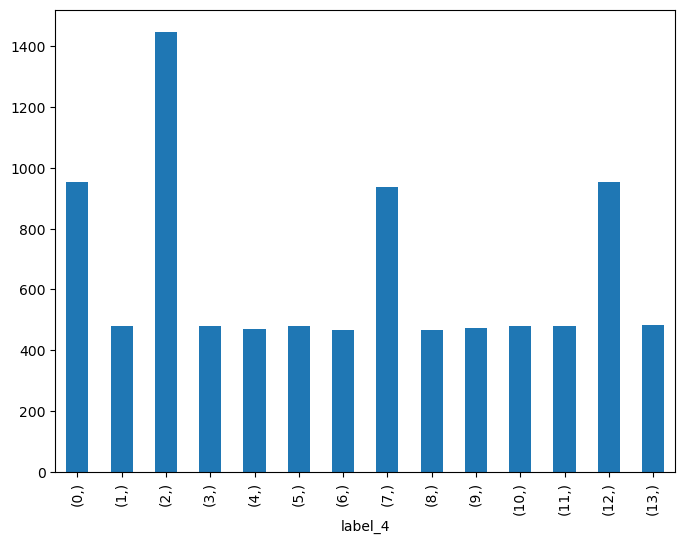

In [34]:
counts = pd.DataFrame(train_df_y_under).value_counts().sort_index()

plt.figure(figsize=(8, 6))
counts.plot(kind='bar')
plt.show()

## Stacking

In this section, *Stacking* ensemble method is tried. KNN and SVM models were stacked and tested for accuracy. But no improvement was observed compared to the individual SVM model in SVM section.

In [12]:
from sklearn.ensemble import StackingClassifier
from sklearn.tree import DecisionTreeClassifier


In [13]:
# define the base models
level0 = list()
level0.append(("knn", KNeighborsClassifier()))
level0.append(("svm", SVC()))
level0.append(("rf", RandomForestClassifier()))

In [59]:
# stacking ensemble
stacked_model_label_1 = StackingClassifier(estimators=level0, final_estimator=DecisionTreeClassifier(random_state=42), cv=5, stack_method="predict", n_jobs=4, verbose=3)
parameters = {
    "knn__n_neighbors": [3, 4 , 5],
    "rf__n_estimators": [100, 150, 200]
}


In [ ]:

grid_1 = GridSearchCV(stacked_model_label_1, parameters, cv=3, verbose=3).fit(train_df_X_pca, train_df_label_1)

In [ ]:
stacked_model_label_1.fit(train_df_X_pca, train_df_label_1)

In [ ]:
joblib.dump(stacked_model_label_1, "./models/stacked_model_label_1_knn_svm_dt.joblib")

In [ ]:
stacked_model_label_1 = joblib.load("./models/stacked_model_label_1.joblib")

In [56]:
print("Train Accuracy: ", grid_1.score(train_df_X_pca, train_df_label_1))
print("Valid Accuracy: ", grid_1.score(valid_df_X_pca, valid_df_label_1))

Train Accuracy:  0.9646914446002806
Valid Accuracy:  0.9213333333333333


## XGBoost

In this section, XGBoost classifier was tested for accuracy.

In [16]:
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

In [ ]:
le = LabelEncoder()
le.fit(train_df_label_1)
train_df_label_1_encoded = le.transform(train_df_label_1)
model_xgb_label_1 = XGBClassifier()
model_xgb_label_1.fit(train_df_X_pca, train_df_label_1_encoded)

In [20]:
print("Train Accuracy: ", model_xgb_label_1.score(train_df_X_pca, train_df_label_1_encoded))
valid_df_label_1_encoded = le.transform(valid_df_label_1)
print("Valid Accuracy: ", model_xgb_label_1.score(valid_df_X_pca, valid_df_label_1_encoded))

Train Accuracy:  1.0
Valid Accuracy:  0.8186666666666667


## HistGradientBoosting

In this section, `HistGradientBoosting` classifier is tested for accuracy.

In [23]:
from sklearn.ensemble import HistGradientBoostingClassifier

In [26]:
model_gbc_label_1 = HistGradientBoostingClassifier()

In [27]:
model_gbc_label_1.fit(train_df_X_pca, train_df_label_1)

HistGradientBoostingClassifier()

In [28]:
print("Train Accuracy: ", model_gbc_label_1.score(train_df_X_pca, train_df_label_1))
print("Valid Accuracy: ", model_gbc_label_1.score(valid_df_X_pca, valid_df_label_1))

Train Accuracy:  0.9833450210378681
Valid Accuracy:  0.8253333333333334


## SVM

In this section, SVM model with Grid Search and Cross Validation is used and tested for accuracy. SVM model gave the best accuracy from all the above tried models. Therefore this model is used for the final predictions for the test data.

### `label_1`

In [ ]:
model_svm_label_1_pca = SVC()

parameters = { "C": [1, 25, 50, 75, 100]}
grid_svm_label_1_pca = GridSearchCV(model_svm_label_1_pca, parameters, cv=5, n_jobs=4, verbose=4)
grid_svm_label_1_pca.fit(train_df_X_pca, train_df_label_1)

In [ ]:
print(grid_svm_label_1_pca.best_params_)

In [12]:
# joblib.dump(grid_svm_label_1_pca, "./models/grid_svm_label_1_pca_2.pkl")
# joblib.dump(grid_svm_label_1_pca.best_estimator_, "./models/model_svm_label_1_pca_2.joblib")
model_svm_label_1_pca = joblib.load("./models/model_svm_label_1_pca.joblib")

In [14]:
print("Train Accuracy: ", model_svm_label_1_pca.score(train_df_X_pca, train_df_label_1))
print("Valid Accuracy: ", model_svm_label_1_pca.score(valid_df_X_pca, valid_df_label_1))

Train Accuracy:  0.9982468443197756
Valid Accuracy:  0.96


### `label_2`

In [ ]:
model_svm_label_2_pca = SVC()

parameters = { "C": [1, 25, 50, 75, 100]}
grid_svm_label_2_pca = GridSearchCV(model_svm_label_2_pca, parameters, cv=5, n_jobs=4, verbose=4)
grid_svm_label_2_pca.fit(train_df_X_missing_removed_pca, train_df_label_2)

In [76]:
print(grid_svm_label_2_pca.best_params_)

{'C': 25}


In [15]:
# joblib.dump(grid_svm_label_2_pca, "./models/grid_svm_label_2_pca_2.pkl")
# joblib.dump(grid_svm_label_2_pca.best_estimator_, "./models/model_svm_label_2_pca_2.joblib")
model_svm_label_2_pca = joblib.load("./models/model_svm_label_2_pca.joblib")

In [16]:
print("Train Accuracy: ", model_svm_label_2_pca.score(train_df_X_missing_removed_pca, train_df_label_2))
print("Valid Accuracy: ", model_svm_label_2_pca.score(valid_df_X_missing_removed_pca, valid_df_label_2))

Train Accuracy:  0.993830242510699
Valid Accuracy:  0.9347826086956522


### `label_3`

In [ ]:
model_svm_label_3_pca = SVC()

parameters = { "C": [1, 25, 50, 75, 100]}
grid_svm_label_3_pca = GridSearchCV(model_svm_label_3_pca, parameters, cv=5, n_jobs=4, verbose=4)
grid_svm_label_3_pca.fit(train_df_X_pca, train_df_label_3)

In [80]:
print(grid_svm_label_3_pca.best_params_)

{'C': 25}


In [101]:
# joblib.dump(grid_svm_label_3_pca, "./models/grid_svm_label_3_pca_2.pkl")
# joblib.dump(grid_svm_label_3_pca.best_estimator_, "./models/model_svm_label_3_pca_2.joblib")
model_svm_label_3_pca = joblib.load("./models/model_svm_label_3_pca.joblib")

In [82]:
print("Train Accuracy: ", grid_svm_label_3_pca.score(train_df_X_pca, train_df_label_3))
print("Valid Accuracy: ", grid_svm_label_3_pca.score(valid_df_X_pca, valid_df_label_3))

Train Accuracy:  0.9990532959326788
Valid Accuracy:  0.9973333333333333


### `label_4` with Under-sampling

In [ ]:
model_svm_label_4_pca = SVC()

parameters = { "C": [1, 25, 50, 75, 100]}
grid_svm_label_4_pca = GridSearchCV(model_svm_label_3_pca, parameters, cv=5, n_jobs=4, verbose=4)
grid_svm_label_4_pca.fit(train_df_X_under, train_df_y_under)

In [84]:
print(grid_svm_label_4_pca.best_params_)

{'C': 25}


In [85]:
# joblib.dump(grid_svm_label_4_pca, "./models/grid_svm_label_4_pca_2.pkl")
# joblib.dump(grid_svm_label_4_pca.best_estimator_, "./models/model_svm_label_4_pca_2.joblib")
model_svm_label_4_pca = joblib.load("./models/model_svm_label_4_pca_2.joblib")

In [ ]:
print("Train Accuracy: ", model_svm_label_4_pca.score(train_df_X_pca, train_df_label_4))
print("Valid Accuracy: ", model_svm_label_4_pca.score(valid_df_X_pca, valid_df_label_4))

### `label_4` without Under-sampling

In [ ]:
model_svm_label_4_pca_no_under_sampling = SVC(class_weight="balanced")

parameters = { "C": [1, 25, 50, 75, 100]}
grid_svm_label_4_pca_no_undersampling = GridSearchCV(model_svm_label_4_pca_no_under_sampling, parameters, cv=5, n_jobs=4, verbose=4)
grid_svm_label_4_pca_no_undersampling.fit(train_df_X_pca, train_df_label_4)

In [88]:
print(grid_svm_label_4_pca.best_params_)

{'C': 25}


In [102]:
# joblib.dump(grid_svm_label_4_pca_no_undersampling, "./models/grid_svm_label_4_pca_no_undersampling_2.pkl")
# joblib.dump(grid_svm_label_4_pca_no_undersampling.best_estimator_, "./models/model_svm_label_4_pca_no_under_sampling_2.joblib")
model_svm_label_4_pca_no_under_sampling = joblib.load("./models/model_svm_label_4_pca_no_under_sampling.joblib")

In [90]:
print("Train Accuracy: ", model_svm_label_4_pca_no_under_sampling.score(train_df_X_pca, train_df_label_4))
print("Valid Accuracy: ", model_svm_label_4_pca_no_under_sampling.score(valid_df_X_pca, valid_df_label_4))

Train Accuracy:  0.9931626928471248
Valid Accuracy:  0.9493333333333334


## Output File Generation

In [ ]:
test_df_X = test_df.iloc[:, 1:]
test_df_X = scaler.transform(test_df_X)
test_df_X_for_label_2 = scaler2.transform(test_df_X)

test_df_X_pca = pca_1.transform(test_df_X)
test_df_X_pca_for_label_2 = pca_2.transform(test_df_X_for_label_2)

predictions = list()
predictions.append(model_svm_label_1_pca.predict(test_df_X_pca))
predictions.append(model_svm_label_2_pca.predict(test_df_X_pca_for_label_2))
predictions.append(model_svm_label_3_pca.predict(test_df_X_pca))
predictions.append(model_svm_label_4_pca_no_under_sampling.predict(test_df_X_pca))

In [104]:
def create_output_dataframe(predictions):
    output_df = pd.DataFrame()
    output_df["ID"] = np.arange(1, len(predictions[0]) + 1)
    for i in range(len(predictions)):
        if (i == 1):
            output_df["label_" + str(i+1)] = predictions[i].astype(int)
        else:
            output_df["label_" + str(i+1)] = predictions[i]
    return output_df

output_df = create_output_dataframe(predictions)

In [105]:
output_df.head()
output_df.to_csv("./output/predictions.csv", index=False)